In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
pd.set_option('display.max_columns', 10)

## Loading the Dataset labels

In [3]:
# Loading the labels
df_labels = pd.read_csv('qm9_labels.csv')
df_labels.head()

,filename,n_atoms,index,A,B,...,U0,U,H,G,Cv
0,qm9_1,5,1,157.71180,157.70997,...,-40.478930,-40.476062,-40.475117,-40.498597,6.469
1,qm9_10,6,10,159.03567,9.22327,...,-132.718150,-132.714563,-132.713619,-132.742149,10.287
2,qm9_100,15,100,7.14221,4.37083,...,-196.406419,-196.400340,-196.399396,-196.435152,22.005
3,qm9_1000,15,1000,3.92760,3.21907,...,-304.742823,-304.735902,-304.734958,-304.773620,24.648
4,qm9_10000,11,10000,2.91858,1.37263,...,-434.553374,-434.545093,-434.544148,-434.588778,26.045


In [ ]:
df_labels.info()

## Loading the Dataset inputs

In [4]:
# Loading the inputs
df_inputs = pd.read_csv('qm9_inputs.csv')
df_inputs.head()

,filename,eig_1,eig_2,eig_3,eig_4,...,eig_25,eig_26,eig_27,eig_28,eig_29
0,qm9_1,1.0,0.000000,0.023048,0.023048,...,0.024529,0.024529,0.024529,0.024529,0.024529
1,qm9_10,1.0,0.299565,0.054755,0.000000,...,0.009634,0.009634,0.009634,0.009634,0.009634
2,qm9_100,1.0,0.289508,0.219977,0.109554,...,0.008284,0.008284,0.008284,0.008284,0.008284
3,qm9_1000,1.0,0.286323,0.236211,0.119480,...,0.005992,0.005992,0.005992,0.005992,0.005992
4,qm9_10000,1.0,0.432691,0.326633,0.240640,...,0.003494,0.003494,0.003494,0.003494,0.003494


In [ ]:
df_inputs.info()

## Pre-processing the data
Most of the labels are important parameters but for the sake of simplicity we will limit our model in prediction of Free Energy G.

In [5]:
target = ['G','Cv']
df_merged = pd.merge(df_inputs, df_labels[['filename', target[0], target[1]]], on='filename', how='left')
df_merged.head()

,filename,eig_1,eig_2,eig_3,eig_4,...,eig_27,eig_28,eig_29,G,Cv
0,qm9_1,1.0,0.000000,0.023048,0.023048,...,0.024529,0.024529,0.024529,-40.498597,6.469
1,qm9_10,1.0,0.299565,0.054755,0.000000,...,0.009634,0.009634,0.009634,-132.742149,10.287
2,qm9_100,1.0,0.289508,0.219977,0.109554,...,0.008284,0.008284,0.008284,-196.435152,22.005
3,qm9_1000,1.0,0.286323,0.236211,0.119480,...,0.005992,0.005992,0.005992,-304.773620,24.648
4,qm9_10000,1.0,0.432691,0.326633,0.240640,...,0.003494,0.003494,0.003494,-434.588778,26.045


In [ ]:
df_merged.info()

## Exploratory Analysis on the data

Perform some analysis on the data showing the ditribution with respect to various labels.
1. Free Energy
2. Specific Heat Capacity

In [ ]:
# Generate random data for the histogram
G = df_merged['G']
Cv = df_merged['Cv']
 
sns.distplot(G, kde=False, fit=stats.norm, bins=25, color='purple')
# Adding labels and title
plt.xlabel('Values')
plt.ylabel('Density')
plt.title('Customized Histogram with Density Plot')
 
# Display the plot
plt.show()


In [ ]:
# sns.histplot(Cv, kde=True, stat='density', fill=True, bins=25)
sns.distplot(Cv, kde=False, fit=stats.norm, bins=25, color='green')

# Adding labels and title
plt.xlabel('Values')
plt.ylabel('Density')
plt.title('Customized Histogram with Density Plot')
 
# Display the plot
plt.show()

## Defining a model to train the data

In [6]:
import pickle

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

In [7]:
X = df_merged.drop(['filename', target[0], target[1]], axis=1)
y = df_merged[target[0]] # G
# y = df_merged[target[1]] # Cv

# Test-Train Splittin
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

We use K-fold cross-validation on both test and train data

In [8]:
# Defining a Scoring function
def get_score(model):
    train_score = -1*cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error').mean()
    valid_score = -1*cross_val_score(model, X_valid, y_valid, cv=5, scoring='neg_mean_absolute_error')
    accuracy = valid_score.mean()
    error = valid_score.std()
    
    print(f"Training Score : {train_score:.3f}")
    print(f"Validation Score : {accuracy:.3f} +/- {error:.6f}\n")
    
def plot_score(func, parameter, values):
    train_list, valid_list = [], []
    for i in values:
        params={parameter:i}
        train_score, valid_score = func(**params)
        train_list.append(train_score)
        valid_list.append(valid_score)
    
    plt.title("Validation Curve")
    plt.ylabel("Score")
    plt.xlabel(parameter)
    plt.plot(values, valid_list, 'b-o', label='Validation')
    
    plt.legend()
    plt.show()

### 1. Linear Regression

In [9]:
%%time
from sklearn.linear_model import LinearRegression

linear = LinearRegression(n_jobs=-1)
linear.fit(X_train, y_train)

get_score(linear)

Training Score : 9.937
Validation Score : 9.867 +/- 0.077696

CPU times: user 6.08 s, sys: 25.8 ms, total: 6.1 s
Wall time: 611 ms


### 2. Decision Tree Regression

In [10]:
%%time
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor(random_state=42)
tree.fit(X_train, y_train)

get_score(tree)

Training Score : 10.250
Validation Score : 12.476 +/- 0.240888

CPU times: user 24.8 s, sys: 47.8 ms, total: 24.8 s
Wall time: 25.9 s


### 3. Random Forest

In [11]:
%%time
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(random_state=42, n_jobs=-1)
forest.fit(X_train, y_train)

get_score(forest)

Training Score : 7.575
Validation Score : 9.043 +/- 0.090135

CPU times: user 37min 41s, sys: 6.85 s, total: 37min 48s
Wall time: 3min 21s


### 4. LGBoost

In [12]:
%%time
from lightgbm import LGBMRegressor

lgbm = LGBMRegressor(random_state=42, n_jobs=-1, learning_rate=0.075, n_estimators=1000)
lgbm.fit(X_train, y_train)

get_score(lgbm)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002256 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7140
[LightGBM] [Info] Number of data points in the train set: 104544, number of used features: 28
[LightGBM] [Info] Start training from score -410.852749
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002590 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7140
[LightGBM] [Info] Number of data points in the train set: 83635, number of used features: 28
[LightGBM] [Info] Start training from score -410.922538
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002638 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7140
[LightGBM] [Info] Number of data points in the tr

### 5. XGBoost

In [13]:
%%time
from xgboost import XGBRegressor

xgbm = XGBRegressor(n_estimators=1000, learning_rate=0.075)
xgbm.fit(X_train, y_train)

get_score(xgbm)

Training Score : 6.027
Validation Score : 6.857 +/- 0.042556

CPU times: user 7min 10s, sys: 711 ms, total: 7min 11s
Wall time: 36.6 s


### Saving the best models

In [ ]:
folder = 'G'
# folder = 'Cv'

pickle.dump(linear, open(f'{folder}/linear_model.sav','wb'))
pickle.dump(tree, open(f'{folder}/tree_model.sav','wb'))
pickle.dump(forest, open(f'{folder}/forest_model.sav','wb'))
pickle.dump(lgbm, open(f'{folder}/lgbm_model.sav','wb'))
pickle.dump(xgbm, open(f'{folder}/xgbm_model.sav','wb'))

## Loading the models

In [ ]:
folder = 'G'
# folder = 'Cv'

linear = pickle.load(open(f'{folder}/linear_model.sav','rb'))
tree = pickle.load(open(f'{folder}/tree_model.sav','rb'))
forest = pickle.load(open(f'{folder}/forest_model.sav','rb'))
lgbm = pickle.load(open(f'{folder}/lgbm_model.sav','rb'))
xgbm = pickle.load(open(f'{folder}/xgbm_model.sav','rb'))

## Feature Importance

In [14]:
def feature_importance(model, title):
    importance_df = pd.DataFrame(
        {'Features': X_train.columns,'Importance': model.feature_importances_, 'cols':  sns.color_palette("flare", 29).as_hex()}
        ).sort_values('Importance', ascending=False)

    # Setting your own color pelette
    colors = importance_df['cols'].to_list()
    pelette = sns.set_palette(sns.color_palette(colors))
    
    plt.title(f'{title}',fontsize=16)
    sns.barplot(data=importance_df.head(10), x='Importance', y='Features', hue='Features', palette=pelette)

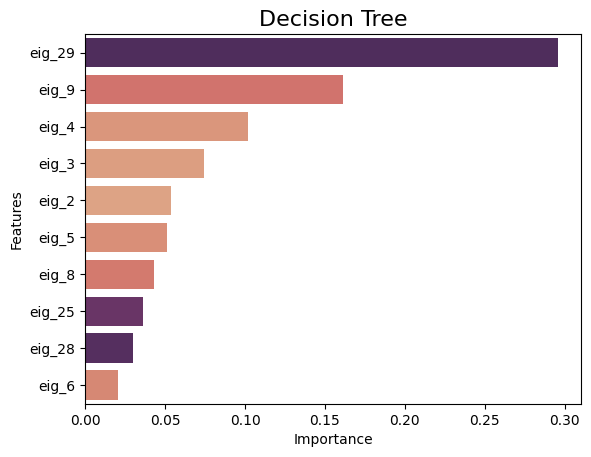

In [15]:
feature_importance(tree, 'Decision Tree')

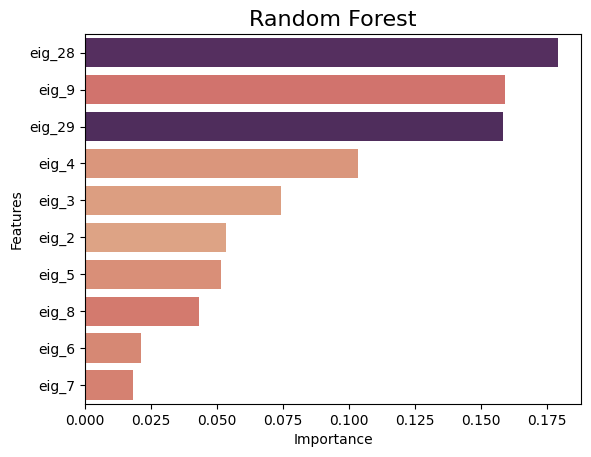

In [16]:
feature_importance(forest, 'Random Forest')

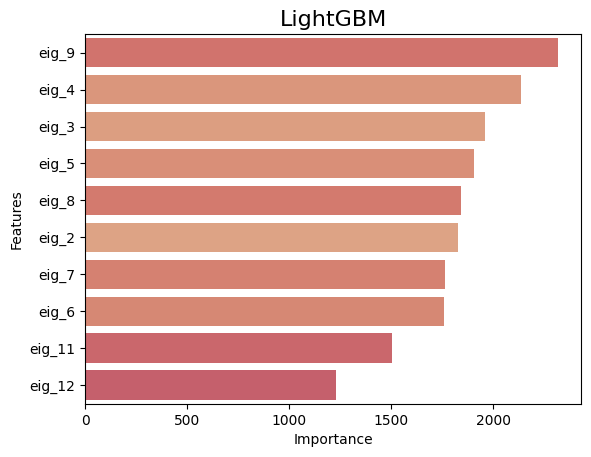

In [17]:
feature_importance(lgbm, 'LightGBM')

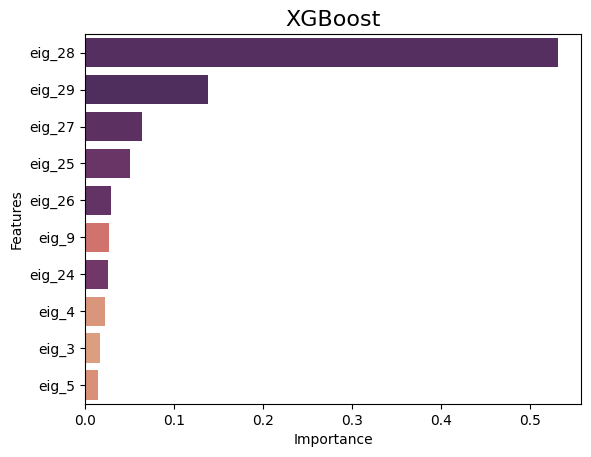

In [19]:
feature_importance(xgbm, 'XGBoost')